# Imports

In [51]:
%matplotlib inline

import src.utils as udf

import gc
import joblib
import datetime
import holidays
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from feature_engine.categorical_encoders import RareLabelCategoricalEncoder as RareEncoder, \
                                                MeanCategoricalEncoder as MeanEncoder, \
                                                OrdinalCategoricalEncoder as OrdinalEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb
import xgboost as xgb
import optuna

In [52]:
# Dataframe settings
pd.set_option('display.max_columns', 50)

# Plot settings
sns.set(rc={'figure.figsize': (16, 4),
            'font.size': 16})

# Data

In [53]:
path = '../data/'

In [54]:
train = pd.read_pickle(f'{path}from_mod/train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [55]:
train = udf.reduce_mem_usage(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18264895 entries, 0 to 18264894
Data columns (total 18 columns):
building_id           uint16
meter                 uint8
meter_reading         float32
dew_temperature       float32
sea_level_pressure    float32
wind_speed            float32
primary_use           object
square_feet           uint32
year_built            uint16
missing_year          uint8
dayofyear             uint16
hour                  uint8
wind_direction_x      float32
wind_direction_y      float32
rel_humidity          float32
is_weekend            uint8
country               object
is_holiday            uint8
dtypes: float32(7), object(2), uint16(3), uint32(1), uint8(5)
memory usage: 1.1+ GB


In [56]:
submission = pd.read_csv(f'{path}raw/test/sample_submission.csv')
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           int64
meter_reading    int64
dtypes: int64(2)
memory usage: 636.3 MB


In [57]:
submission = udf.reduce_mem_usage(submission)
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 2 columns):
row_id           uint32
meter_reading    uint8
dtypes: uint32(1), uint8(1)
memory usage: 198.8 MB


In [58]:
meter = pd.read_csv(f'{path}raw/test/test.csv', parse_dates=['timestamp'])
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         int64
building_id    int64
meter          int64
timestamp      datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.2 GB


In [59]:
meter = udf.reduce_mem_usage(meter)
meter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
row_id         uint32
building_id    uint16
meter          uint8
timestamp      datetime64[ns]
dtypes: datetime64[ns](1), uint16(1), uint32(1), uint8(1)
memory usage: 596.5 MB


In [60]:
weather = pd.read_csv(f'{path}raw/test/weather_test.csv', parse_dates=['timestamp'])
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null int64
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float64
cloud_coverage        136795 non-null float64
dew_temperature       276916 non-null float64
precip_depth_1_hr     181655 non-null float64
sea_level_pressure    255978 non-null float64
wind_direction        264873 non-null float64
wind_speed            276783 non-null float64
dtypes: datetime64[ns](1), float64(7), int64(1)
memory usage: 19.0 MB


In [61]:
weather = udf.reduce_mem_usage(weather)
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277243 entries, 0 to 277242
Data columns (total 9 columns):
site_id               277243 non-null uint8
timestamp             277243 non-null datetime64[ns]
air_temperature       277139 non-null float32
cloud_coverage        136795 non-null float32
dew_temperature       276916 non-null float32
precip_depth_1_hr     181655 non-null float32
sea_level_pressure    255978 non-null float32
wind_direction        264873 non-null float32
wind_speed            276783 non-null float32
dtypes: datetime64[ns](1), float32(7), uint8(1)
memory usage: 9.8 MB


In [62]:
building = pd.read_csv(f'{path}from_pre/building.csv')
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id         1449 non-null int64
building_id     1449 non-null int64
primary_use     1449 non-null object
square_feet     1449 non-null int64
year_built      1449 non-null int64
missing_year    1449 non-null int64
dtypes: int64(5), object(1)
memory usage: 68.0+ KB


In [63]:
building = udf.reduce_mem_usage(building)
building.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id         1449 non-null uint8
building_id     1449 non-null uint16
primary_use     1449 non-null object
square_feet     1449 non-null uint32
year_built      1449 non-null uint16
missing_year    1449 non-null uint8
dtypes: object(1), uint16(2), uint32(1), uint8(2)
memory usage: 25.6+ KB


In [64]:
del path
gc.collect()

132

# Preprocessing

### Convert weather to local time

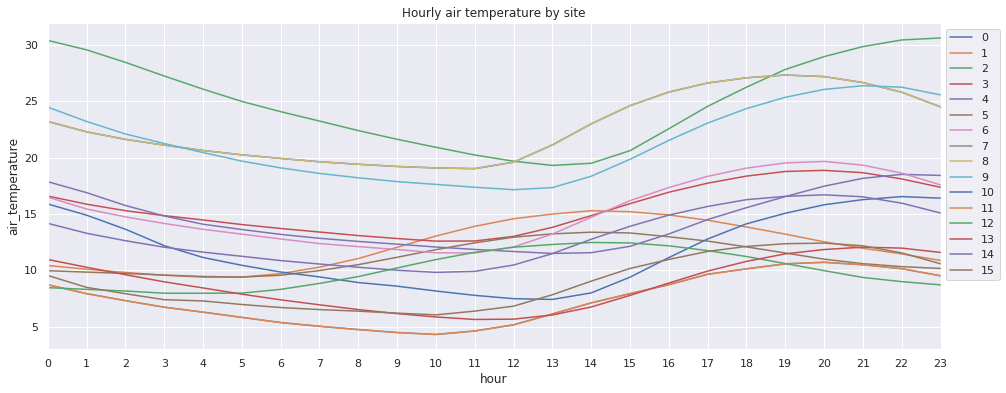

In [65]:
weather['hour'] = weather.timestamp.dt.hour

airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')

airtemp.plot(figsize=(16, 6), xticks=range(24), title='Hourly air temperature by site')
plt.ylabel('air_temperature')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True);

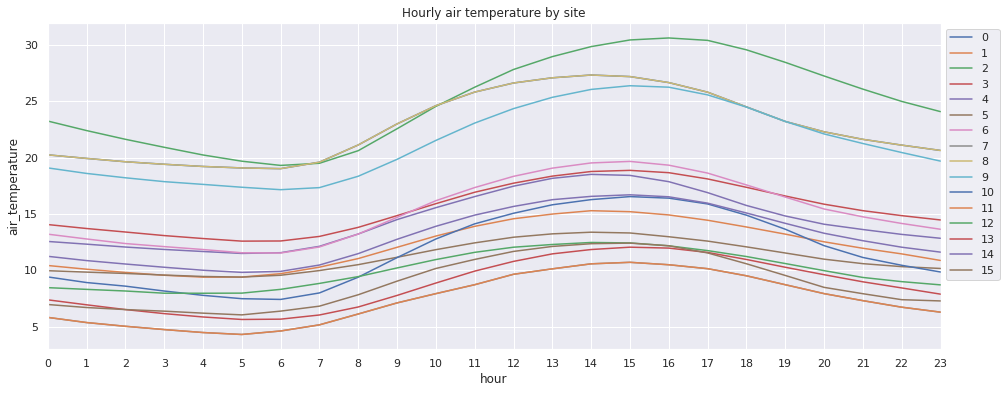

In [66]:
timezones = [-5, 0, -7, -5, -8, 0, -5, -5, -5, -6, -7, -5, 0, -6, -5, -5]

weather = udf.to_local_time(weather, timezones)
weather['hour'] = weather.timestamp.dt.hour

airtemp = pd.pivot_table(weather, index='hour', columns='site_id', values='air_temperature', aggfunc='mean')

airtemp.plot(figsize=(16, 6), xticks=range(24), title='Hourly air temperature by site')
plt.ylabel('air_temperature')
plt.legend(bbox_to_anchor=(1, 1), fancybox=True);

In [67]:
del airtemp, timezones

### Reindex weather

In [68]:
weather = udf.reidx_site_time(weather, tstart='1/1/2017 00:00:00', tend='12/31/2018 23:00:00')
weather['hour'] = weather.timestamp.dt.hour
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280320 entries, 0 to 280319
Data columns (total 10 columns):
site_id               280320 non-null uint64
timestamp             280320 non-null datetime64[ns]
air_temperature       277071 non-null float32
cloud_coverage        136767 non-null float32
dew_temperature       276848 non-null float32
precip_depth_1_hr     181593 non-null float32
sea_level_pressure    255910 non-null float32
wind_direction        264805 non-null float32
wind_speed            276715 non-null float32
hour                  280320 non-null int64
dtypes: datetime64[ns](1), float32(7), int64(1), uint64(1)
memory usage: 13.9 MB


### Missing weather values

In [69]:
pd.DataFrame(zip(weather.isnull().sum(), np.round(weather.isnull().mean() * 100, 2)), 
             index=weather.columns, 
             columns=['missing', 'pct_missing'])

,missing,pct_missing
site_id,0,0.00
timestamp,0,0.00
air_temperature,3249,1.16
cloud_coverage,143553,51.21
dew_temperature,3472,1.24
precip_depth_1_hr,98727,35.22
sea_level_pressure,24410,8.71
wind_direction,15515,5.53
wind_speed,3605,1.29
hour,0,0.00


In [70]:
udf.locate_missing(weather, pct=True)

,timestamp,pct_missing_air_temperature,pct_missing_cloud_coverage,pct_missing_dew_temperature,pct_missing_precip_depth_1_hr,pct_missing_sea_level_pressure,pct_missing_wind_direction,pct_missing_wind_speed,pct_missing_hour
site_id,,,,,,,,,
0,17520,0.03,43.08,0.03,0.19,1.79,2.75,0.04,0.0
1,17520,1.46,79.37,1.46,100.00,1.70,1.36,1.33,0.0
2,17520,0.04,31.09,0.05,0.15,0.23,6.85,0.09,0.0
3,17520,0.06,44.84,0.06,0.29,2.19,1.48,0.09,0.0
4,17520,0.06,45.89,0.08,1.67,0.74,1.23,0.06,0.0
5,17520,1.59,66.35,1.60,100.00,100.00,4.65,1.60,0.0
6,17520,0.14,37.02,0.14,0.37,2.33,8.17,0.41,0.0
7,17520,5.43,100.00,5.72,89.77,5.67,5.43,5.43,0.0
8,17520,0.03,43.08,0.03,0.19,1.79,2.75,0.04,0.0


In [71]:
weather.drop(['cloud_coverage', 'precip_depth_1_hr'], axis=1, inplace=True)
weather.head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
0,0,2017-01-01 00:00:00,15.6,12.8,1022.099976,130.0,2.1,0
1,0,2017-01-01 01:00:00,15.0,12.8,1021.700012,150.0,1.5,1
2,0,2017-01-01 02:00:00,15.0,13.3,1021.599976,0.0,0.0,2
3,0,2017-01-01 03:00:00,13.3,12.2,1021.400024,0.0,0.0,3
4,0,2017-01-01 04:00:00,12.2,11.7,1021.400024,0.0,0.0,4


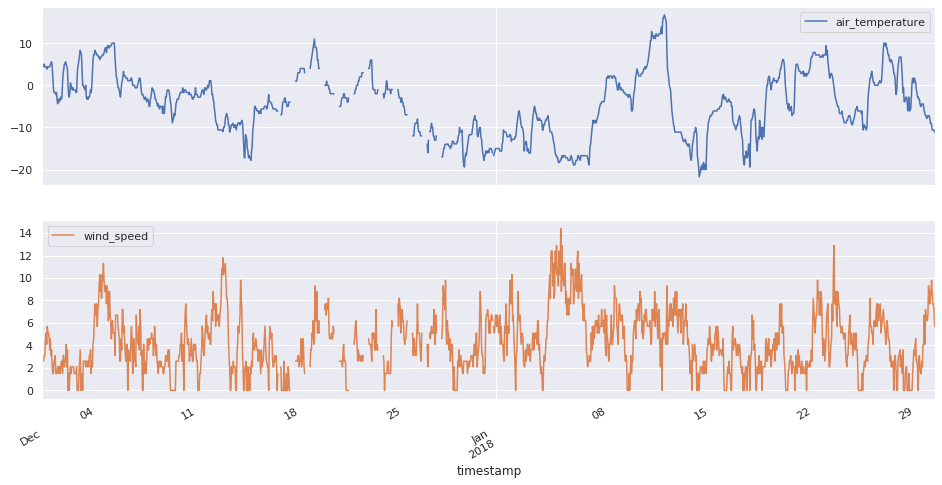

In [72]:
start, end = datetime.date(2017, 12, 1), datetime.date(2018, 1, 31)

w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, figsize=(16, 8));

In [73]:
lin_cols = ['wind_direction', 'wind_speed']
cub_cols = ['air_temperature', 'dew_temperature', 'sea_level_pressure']

weather = udf.fill_missing(weather, [], lin_cols, cub_cols)
udf.locate_missing(weather, pct=True)

,timestamp,pct_missing_air_temperature,pct_missing_dew_temperature,pct_missing_sea_level_pressure,pct_missing_wind_direction,pct_missing_wind_speed,pct_missing_hour
site_id,,,,,,,
0,17520,0.0,0.0,0.0,0.0,0.0,0.0
1,17520,0.0,0.0,0.0,0.0,0.0,0.0
2,17520,0.0,0.0,0.0,0.0,0.0,0.0
3,17520,0.0,0.0,0.0,0.0,0.0,0.0
4,17520,0.0,0.0,0.0,0.0,0.0,0.0
5,17520,0.0,0.0,100.0,0.0,0.0,0.0
6,17520,0.0,0.0,0.0,0.0,0.0,0.0
7,17520,0.0,0.0,0.0,0.0,0.0,0.0
8,17520,0.0,0.0,0.0,0.0,0.0,0.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f56f995ee20>,
      dtype=object)

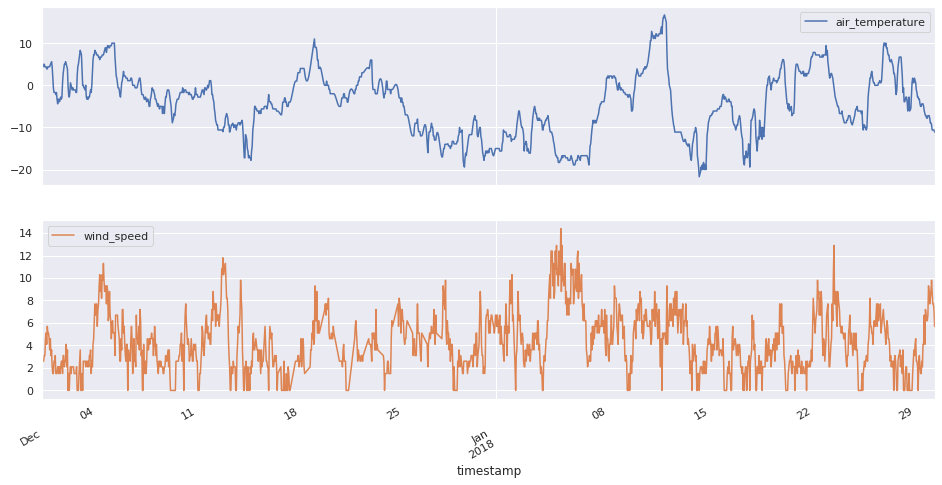

In [74]:
w15 = udf.get_site(weather, 15, time_idx=True)
w15.loc[start:end, ['air_temperature', 'wind_speed']].plot(subplots=True, figsize=(16, 8))

In [75]:
weather[weather.site_id == 1].head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
17520,1,2017-01-01 00:00:00,6.7,5.2,1024.099976,200.0,5.1,0
17521,1,2017-01-01 01:00:00,6.2,5.1,1022.700012,210.0,3.6,1
17522,1,2017-01-01 02:00:00,6.0,4.9,1021.900024,210.0,4.6,2
17523,1,2017-01-01 03:00:00,5.7,4.8,1020.700012,200.0,3.6,3
17524,1,2017-01-01 04:00:00,5.6,4.5,1019.599976,210.0,4.1,4


In [76]:
i1 = weather[weather.site_id == 1].index 
i5 = weather[weather.site_id == 5].index

weather.loc[i5, 'sea_level_pressure'] = weather.loc[i1, 'sea_level_pressure'].values
weather[weather.site_id == 5].head()

,site_id,timestamp,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
87600,5,2017-01-01 00:00:00,9.0,7.0,1024.099976,240.0,3.6,0
87601,5,2017-01-01 01:00:00,9.0,7.0,1022.700012,240.0,3.6,1
87602,5,2017-01-01 02:00:00,9.0,8.0,1021.900024,240.0,3.1,2
87603,5,2017-01-01 03:00:00,8.0,8.0,1020.700012,270.0,3.6,3
87604,5,2017-01-01 04:00:00,8.0,8.0,1019.599976,240.0,4.1,4


In [77]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280320 entries, 0 to 280319
Data columns (total 8 columns):
site_id               280320 non-null uint64
timestamp             280320 non-null datetime64[ns]
air_temperature       280320 non-null float32
dew_temperature       280320 non-null float32
sea_level_pressure    280320 non-null float32
wind_direction        280320 non-null float32
wind_speed            280320 non-null float32
hour                  280320 non-null int64
dtypes: datetime64[ns](1), float32(5), int64(1), uint64(1)
memory usage: 11.8 MB


In [78]:
del start, end, w15, lin_cols, cub_cols, i1, i5

### Merge dataframes

In [79]:
path = '../data/from_sub/mb.pkl'
mb = pd.merge(meter, building, on='building_id', how='left')
mb.to_pickle(path)
pd.read_pickle(path)

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,missing_year
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008,0
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004,0
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991,0
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002,0
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975,0
...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914,0
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,1964,1
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997,0
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001,0


In [30]:
test = pd.merge(mb, weather, on=['site_id', 'timestamp'], how='left')
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,missing_year,air_temperature,dew_temperature,sea_level_pressure,wind_direction,wind_speed,hour
0,0,0,0,2017-01-01,0,Education,7432,2008,0,15.6,12.8,1022.099976,130.0,2.1,0
1,1,1,0,2017-01-01,0,Education,2720,2004,0,15.6,12.8,1022.099976,130.0,2.1,0
2,2,2,0,2017-01-01,0,Education,5376,1991,0,15.6,12.8,1022.099976,130.0,2.1,0
3,3,3,0,2017-01-01,0,Education,23685,2002,0,15.6,12.8,1022.099976,130.0,2.1,0
4,4,4,0,2017-01-01,0,Education,116607,1975,0,15.6,12.8,1022.099976,130.0,2.1,0


In [31]:
del meter, weather, building
gc.collect()

10456

# Features

### Convert wind_direction to x and y components

In [32]:
test = udf.deg_to_components(test, 'wind_direction')
test.drop('wind_direction', axis=1, inplace=True)
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,missing_year,air_temperature,dew_temperature,sea_level_pressure,wind_speed,hour,wind_direction_x,wind_direction_y
0,0,0,0,2017-01-01,0,Education,7432,2008,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044
1,1,1,0,2017-01-01,0,Education,2720,2004,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044
2,2,2,0,2017-01-01,0,Education,5376,1991,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044
3,3,3,0,2017-01-01,0,Education,23685,2002,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044
4,4,4,0,2017-01-01,0,Education,116607,1975,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044


### Create relative humidity feature

In [33]:
test['rel_humidity'] = udf.calc_rel_humidity(test.air_temperature, test.dew_temperature)
test.describe()

,row_id,building_id,meter,site_id,square_feet,year_built,missing_year,air_temperature,dew_temperature,sea_level_pressure,wind_speed,hour,wind_direction_x,wind_direction_y,rel_humidity
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.075824e+02,6.642857e-01,8.086134e+00,1.069469e+05,1.967411e+03,5.899160e-01,1.545894e+01,7.558217e+00,1.016237e+03,3.387125e+00,1.150000e+01,-5.607646e-02,-5.065178e-02,6.548797e+01
std,1.203706e+07,4.297680e+02,9.278067e-01,5.134712e+00,1.160888e+05,2.007026e+01,4.918487e-01,1.131472e+01,1.057333e+01,7.777517e+00,2.235481e+00,6.922187e+00,6.687698e-01,6.545256e-01,2.374821e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,0.000000e+00,-2.810000e+01,-3.160000e+01,9.720000e+02,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,2.113540e+00
25%,1.042440e+07,4.047500e+02,0.000000e+00,3.000000e+00,3.224350e+04,1.963000e+03,0.000000e+00,7.800000e+00,0.000000e+00,1.011400e+03,2.100000e+00,5.750000e+00,-7.660445e-01,-6.427876e-01,4.891239e+01
50%,2.084880e+07,9.000000e+02,0.000000e+00,9.000000e+00,7.226250e+04,1.965000e+03,1.000000e+00,1.670000e+01,8.900000e+00,1.016100e+03,3.100000e+00,1.150000e+01,0.000000e+00,0.000000e+00,6.917134e+01
75%,3.127320e+07,1.194250e+03,1.000000e+00,1.300000e+01,1.383875e+05,1.972000e+03,1.000000e+00,2.390000e+01,1.630000e+01,1.020700e+03,4.600000e+00,1.725000e+01,5.000004e-01,4.999998e-01,8.557770e+01
max,4.169760e+07,1.448000e+03,3.000000e+00,1.500000e+01,8.750000e+05,2.017000e+03,1.000000e+00,4.830000e+01,2.670000e+01,1.055936e+03,2.420000e+01,2.300000e+01,1.000000e+00,1.000000e+00,2.208222e+02


### Create day components

In [34]:
test = udf.extract_from_dt(test, ['dayofyear', 'dayofweek'])
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,missing_year,air_temperature,dew_temperature,sea_level_pressure,wind_speed,hour,wind_direction_x,wind_direction_y,rel_humidity,dayofyear,dayofweek
0,0,0,0,2017-01-01,0,Education,7432,2008,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6
1,1,1,0,2017-01-01,0,Education,2720,2004,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6
2,2,2,0,2017-01-01,0,Education,5376,1991,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6
3,3,3,0,2017-01-01,0,Education,23685,2002,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6
4,4,4,0,2017-01-01,0,Education,116607,1975,0,15.6,12.8,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6


In [35]:
test['is_weekend'] = test.dayofweek.apply(lambda d: int(d in [5, 6]))
test.tail()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,missing_year,air_temperature,dew_temperature,sea_level_pressure,wind_speed,hour,wind_direction_x,wind_direction_y,rel_humidity,dayofyear,dayofweek,is_weekend
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914,0,16.1,10.0,1020.5,2.6,7,-0.34202,0.939693,67.105179,129,2,0
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,1964,1,16.1,10.0,1020.5,2.6,7,-0.34202,0.939693,67.105179,129,2,0
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997,0,16.1,10.0,1020.5,2.6,7,-0.34202,0.939693,67.105179,129,2,0
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001,0,16.1,10.0,1020.5,2.6,7,-0.34202,0.939693,67.105179,129,2,0
41697599,41697599,1448,0,2018-05-09 07:00:00,15,Office,92271,2001,0,16.1,10.0,1020.5,2.6,7,-0.34202,0.939693,67.105179,129,2,0


### Create country and holiday features

In [36]:
countries = {0: 'US', 1: 'UK', 2: 'US', 3: 'US', 4: 'US', 5: 'UK', 6: 'US', 7: 'CA', 8: 'US', 9: 'US', 10: 'US', 11: 'CA', 12: 'IE', 13: 'US', 14: 'US', 15: 'US'}
test['country'] = test.site_id.map(countries)
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,missing_year,air_temperature,...,sea_level_pressure,wind_speed,hour,wind_direction_x,wind_direction_y,rel_humidity,dayofyear,dayofweek,is_weekend,country
0,0,0,0,2017-01-01,0,Education,7432,2008,0,15.6,...,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US
1,1,1,0,2017-01-01,0,Education,2720,2004,0,15.6,...,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US
2,2,2,0,2017-01-01,0,Education,5376,1991,0,15.6,...,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US
3,3,3,0,2017-01-01,0,Education,23685,2002,0,15.6,...,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US
4,4,4,0,2017-01-01,0,Education,116607,1975,0,15.6,...,1022.099976,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US


In [37]:
US_holidays = holidays.UnitedStates()     # sites 0, 2, 3, 4, 6, 8, 9, 10, 13, 14, 15 
CA_holidays = holidays.Canada()           # sites 7, 11
UK_holidays = holidays.UnitedKingdom()    # sites 1, 5
IE_holidays = holidays.Ireland()          # site 12

In [38]:
test_US = test[test.country == 'US'].copy()
test_CA = test[test.country == 'CA'].copy()
test_UK = test[test.country == 'UK'].copy()
test_IE = test[test.country == 'IE'].copy()

In [39]:
test_US['is_holiday'] = test_US.timestamp.map(lambda d: int(d in US_holidays))
test_CA['is_holiday'] = test_CA.timestamp.map(lambda d: int(d in CA_holidays))
test_UK['is_holiday'] = test_UK.timestamp.map(lambda d: int(d in UK_holidays))
test_IE['is_holiday'] = test_IE.timestamp.map(lambda d: int(d in IE_holidays))

In [40]:
test = pd.concat([test_US, test_CA, test_UK, test_IE]).sort_index()
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,missing_year,air_temperature,...,wind_speed,hour,wind_direction_x,wind_direction_y,rel_humidity,dayofyear,dayofweek,is_weekend,country,is_holiday
0,0,0,0,2017-01-01,0,Education,7432,2008,0,15.6,...,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US,1
1,1,1,0,2017-01-01,0,Education,2720,2004,0,15.6,...,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US,1
2,2,2,0,2017-01-01,0,Education,5376,1991,0,15.6,...,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US,1
3,3,3,0,2017-01-01,0,Education,23685,2002,0,15.6,...,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US,1
4,4,4,0,2017-01-01,0,Education,116607,1975,0,15.6,...,2.1,0,-0.642788,0.766044,83.409012,1,6,1,US,1


In [41]:
test = test[train.drop('meter_reading', axis=1).columns]
test.head()

,building_id,meter,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,0,12.8,1022.099976,2.1,Education,7432,2008,0,1,0,-0.642788,0.766044,83.409012,1,US,1
1,1,0,12.8,1022.099976,2.1,Education,2720,2004,0,1,0,-0.642788,0.766044,83.409012,1,US,1
2,2,0,12.8,1022.099976,2.1,Education,5376,1991,0,1,0,-0.642788,0.766044,83.409012,1,US,1
3,3,0,12.8,1022.099976,2.1,Education,23685,2002,0,1,0,-0.642788,0.766044,83.409012,1,US,1
4,4,0,12.8,1022.099976,2.1,Education,116607,1975,0,1,0,-0.642788,0.766044,83.409012,1,US,1


In [42]:
path = '../data/from_sub/'
test.to_pickle(f'{path}test.pkl')
pd.read_pickle(f'{path}test.pkl')

,building_id,meter,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,0,0,12.8,1022.099976,2.1,Education,7432,2008,0,1,0,-0.642788,0.766044,83.409012,1,US,1
1,1,0,12.8,1022.099976,2.1,Education,2720,2004,0,1,0,-0.642788,0.766044,83.409012,1,US,1
2,2,0,12.8,1022.099976,2.1,Education,5376,1991,0,1,0,-0.642788,0.766044,83.409012,1,US,1
3,3,0,12.8,1022.099976,2.1,Education,23685,2002,0,1,0,-0.642788,0.766044,83.409012,1,US,1
4,4,0,12.8,1022.099976,2.1,Education,116607,1975,0,1,0,-0.642788,0.766044,83.409012,1,US,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,1444,0,10.0,1020.500000,2.6,Entertainment/public assembly,19619,1914,0,129,7,-0.342020,0.939693,67.105179,0,US,0
41697596,1445,0,10.0,1020.500000,2.6,Education,4298,1964,1,129,7,-0.342020,0.939693,67.105179,0,US,0
41697597,1446,0,10.0,1020.500000,2.6,Entertainment/public assembly,11265,1997,0,129,7,-0.342020,0.939693,67.105179,0,US,0
41697598,1447,0,10.0,1020.500000,2.6,Lodging/residential,29775,2001,0,129,7,-0.342020,0.939693,67.105179,0,US,0


In [43]:
del countries, US_holidays, CA_holidays, UK_holidays, IE_holidays, test_US, test_CA, test_UK, test_IE
gc.collect()

22

# Split data

In [44]:
train.head()

,building_id,meter,meter_reading,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,46,0,15.604556,19.4,1019.400024,0.0,Retail,9045,2016,0,1,0,0.0,0.000000,100.000000,0,US,1
1,74,0,12.603682,19.4,1019.400024,0.0,Parking,387638,1997,0,1,0,0.0,0.000000,100.000000,0,US,1
2,93,0,15.364478,19.4,1019.400024,0.0,Office,33370,1982,0,1,0,0.0,0.000000,100.000000,0,US,1
3,105,0,23.303600,2.4,1020.900024,3.1,Education,50623,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1
4,106,0,0.374600,2.4,1020.900024,3.1,Education,5374,1960,1,1,0,-0.5,-0.866025,90.549408,0,UK,1


In [45]:
train_df = []
test_df = []

for m in range(4):
    df_train = train[train.meter == m].drop('meter', axis=1)
    df_test = test[test.meter == m].drop('meter', axis=1)
    train_df.append(df_train)
    test_df.append(df_test)
    df_test.to_pickle(f'{path}test_meter{m}.pkl')
    print(f'Meter {m}:', df_train.shape, df_test.shape)

Meter 0: (11530268, 17) (24755760, 16)
Meter 1: (3518870, 17) (8724960, 16)
Meter 2: (2296049, 17) (5676480, 16)
Meter 3: (919708, 17) (2540400, 16)


In [46]:
del m, df_train, df_test
gc.collect()

22

# Functions

In [47]:
def transform_data(df_train, df_test):
    X_train = df_train.drop('meter_reading', axis=1)
    y_train = df_train[['meter_reading']]
    y_train = np.log1p(y_train)
    
    X_train, X_val, X_test, rare_dict = udf.rare_encoder(X_train, df_test, ['primary_use'])
    X_train, X_val, X_test, mean_dict = udf.mean_encoder(X_train, y_train, X_test, ['primary_use', 'country'])
    X_train_scaled, X_val, X_test_scaled = udf.scale_feats(X_train, X_test)
    
    return X_train_scaled, X_test_scaled, y_train

In [48]:
def predict_lgb(X_train, y_train, X_test, params_dict, save_path):
    dtrain = lgb.Dataset(X_train, label=y_train)
    lgbm = lgb.train(params_dict, dtrain, valid_sets=[dtrain], valid_names=['train'], verbose_eval=False)
#     lgbm.save_model(save_path)
    joblib.dump(lgbm, save_path)
    
    pred = lgbm.predict(X_test)
    pred[pred < 0] = 0
    return pred

In [49]:
def predict_xgb(X_train, y_train, X_test, params_dict, save_path):
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    xg = xgb.train(params_dict, dtrain, evals=[(dtrain, 'train')], num_boost_round=1000, early_stopping_rounds=10, verbose_eval=False)
#     xg.save_model(save_path)
    joblib.dump(xg, save_path)
    
    pred = xg.predict(dtest)
    pred[pred < 0] = 0
    return pred

In [50]:
gc.collect()

88

# Electricity meter

### Transform data

In [86]:
Xe_train_scaled, Xe_test_scaled, ye_train = transform_data(train_df[0], test_df[0])
Xe_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,-1.665489,1.136225,0.418458,-1.532377,-1.035516,-0.747902,2.314036,-1.103144,-1.782112,-1.661713,0.065518,0.093720,1.542446,-0.633757,0.183620,5.545828
1,-1.596500,1.136225,0.418458,-1.532377,-1.035516,2.635689,1.426743,-1.103144,-1.782112,-1.661713,0.065518,0.093720,1.542446,-0.633757,0.183620,5.545828
2,-1.549687,1.136225,0.418458,-1.532377,0.252910,-0.530502,0.726249,-1.103144,-1.782112,-1.661713,0.065518,0.093720,1.542446,-0.633757,0.183620,5.545828
3,-1.520120,-0.583310,0.620950,-0.197577,1.047964,-0.376308,-0.301143,0.906500,-1.782112,-1.661713,-0.677069,-1.220925,1.119560,-0.633757,-2.124149,5.545828
4,-1.517656,-0.583310,0.620950,-0.197577,1.047964,-0.780710,-0.301143,0.906500,-1.782112,-1.661713,-0.677069,-1.220925,1.119560,-0.633757,-2.124149,5.545828


### Lasso Regression

In [87]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xe_train_scaled, ye_train)

lasso0 = lasso.predict(Xe_test_scaled)
lasso0[lasso0 < 0] = 0
lasso0

array([3.56413138, 3.50363612, 3.43702178, ..., 3.41301686, 3.94953955,
       4.58193633])

### LightGBM

In [52]:
study_lgb0 = joblib.load('../objects/electricity/study_lgb.pkl')
print(f'Finished trials: {len(study_lgb0.trials)}')
print(f'Best trial: {study_lgb0.best_trial.value}')
params_lgb0 = study_lgb0.best_trial.params
params_lgb0

Finished trials: 100
Best trial: 0.0018293180635630408


{'learning_rate': 0.07916336777546343,
 'lambda_l1': 0.008557356431137609,
 'lambda_l2': 0.0006037228650908533,
 'max_depth': 51,
 'num_leaves': 923,
 'min_child_samples': 7,
 'subsample': 0.7399597912518232,
 'feature_fraction': 0.7310599981838332}

In [53]:
params_lgb0['num_iterations'] = 10000
params_lgb0['early_stopping_round'] = 10
params_lgb0['metric'] = 'rmse'
params_lgb0['num_threads'] = -1
params_lgb0['seed'] = 42
params_lgb0

{'learning_rate': 0.07916336777546343,
 'lambda_l1': 0.008557356431137609,
 'lambda_l2': 0.0006037228650908533,
 'max_depth': 51,
 'num_leaves': 923,
 'min_child_samples': 7,
 'subsample': 0.7399597912518232,
 'feature_fraction': 0.7310599981838332,
 'num_iterations': 10000,
 'early_stopping_round': 10,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [54]:
lgbm0 = predict_lgb(Xe_train_scaled, ye_train, Xe_test_scaled, params_lgb0, '../objects/submission/lgb0.pkl') # .txt')
lgbm0

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([2.83701467, 1.83561491, 0.35982198, ..., 2.11246576, 5.15925485,
       1.59702006])

### XGBoost

In [55]:
study_xgb0 = joblib.load('../objects/electricity/study_xgb.pkl')
print(f'Finished trials: {len(study_xgb0.trials)}')
print(f'Best trial: {study_xgb0.best_trial.value}')

params_xgb0 = study_xgb0.best_trial.params
params_xgb0['eval_metric'] = 'rmse'
params_xgb0['seed'] = 42
params_xgb0

Finished trials: 50
Best trial: 0.0020912776235491037


{'grow_policy': 'lossguide',
 'learning_rate': 0.014754037383886122,
 'alpha': 0.005261717289274988,
 'lambda': 0.10981652452119427,
 'gamma': 0.00015007710756172543,
 'max_depth': 23,
 'max_leaves': 1598,
 'subsample': 0.8406224713599797,
 'colsample_bytree': 0.9175035245877109,
 'eval_metric': 'rmse',
 'seed': 42}

In [56]:
xg0 = predict_xgb(Xe_train_scaled, ye_train, Xe_test_scaled, params_xgb0, '../objects/submission/xgb0.pkl') # .txt')
xg0

[00:31:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


array([2.7854292 , 1.7767608 , 0.73632723, ..., 2.2183475 , 5.157854  ,
       1.6375346 ], dtype=float32)

In [57]:
del lasso, study_lgb0
gc.collect()

88

# Chilled water meter

### Transform data

In [58]:
Xc_train_scaled, Xc_test_scaled, yc_train = transform_data(train_df[1], test_df[1])
Xc_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,-1.591378,-1.372218,0.309256,-1.42888,0.758045,-0.478269,0.075476,-1.370791,-1.880578,-1.686758,0.113694,-0.009177,-0.782728,-0.625362,-0.173847,5.873399
1,-1.584600,-1.372218,0.309256,-1.42888,-0.342804,3.612160,2.243055,-1.370791,-1.880578,-1.686758,0.113694,-0.009177,-0.782728,-0.625362,-0.173847,5.873399
2,-1.580082,-1.372218,0.309256,-1.42888,0.758045,0.468508,2.020739,-1.370791,-1.880578,-1.686758,0.113694,-0.009177,-0.782728,-0.625362,-0.173847,5.873399
3,-1.577823,-1.372218,0.309256,-1.42888,0.758045,0.435342,2.076318,-1.370791,-1.880578,-1.686758,0.113694,-0.009177,-0.782728,-0.625362,-0.173847,5.873399
4,-1.575563,-1.372218,0.309256,-1.42888,0.694563,-0.706788,0.742423,-1.370791,-1.880578,-1.686758,0.113694,-0.009177,-0.782728,-0.625362,-0.173847,5.873399


### Lasso Regression

In [59]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xc_train_scaled, yc_train)

lasso1 = lasso.predict(Xc_test_scaled)
lasso1[lasso1 < 0] = 0
lasso1

array([4.01847991, 3.12233615, 4.00519928, ..., 4.04518521, 3.88790247,
       4.23308682])

### LightGBM

In [60]:
study_lgb1 = joblib.load('../objects/chilledwater/study_lgb1.pkl')
print(f'Finished trials: {len(study_lgb1.trials)}')
print(f'Best trial: {study_lgb1.best_trial.value}')
params_lgb1 = study_lgb1.best_trial.params
params_lgb1

Finished trials: 50
Best trial: 0.009449663067638923


{'learning_rate': 0.020424864262841822,
 'lambda_l1': 0.27986455703148144,
 'lambda_l2': 7.08804479307531,
 'max_depth': 32,
 'num_leaves': 1293,
 'min_data_in_leaf': 23,
 'bagging_fraction': 0.9143657877950819,
 'feature_fraction': 0.701556769695671}

In [61]:
params_lgb1['num_iterations'] = 10000
params_lgb1['early_stopping_round'] = 20
params_lgb1['metric'] = 'rmse'
params_lgb1['num_threads'] = -1
params_lgb1['seed'] = 42
params_lgb1

{'learning_rate': 0.020424864262841822,
 'lambda_l1': 0.27986455703148144,
 'lambda_l2': 7.08804479307531,
 'max_depth': 32,
 'num_leaves': 1293,
 'min_data_in_leaf': 23,
 'bagging_fraction': 0.9143657877950819,
 'feature_fraction': 0.701556769695671,
 'num_iterations': 10000,
 'early_stopping_round': 20,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [62]:
lgbm1 = predict_lgb(Xc_train_scaled, yc_train, Xc_test_scaled, params_lgb1, '../objects/submission/lgb1.pkl') # .txt')
lgbm1

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([4.03324389, 1.0988268 , 2.85497327, ..., 0.97904193, 0.25365443,
       1.92914143])

### XGBoost

In [63]:
study_xgb1 = joblib.load('../objects/chilledwater/study_xgb1.pkl')
print(f'Finished trials: {len(study_xgb1.trials)}')
print(f'Best trial: {study_xgb1.best_trial.value}')

params_xgb1 = study_xgb1.best_trial.params
params_xgb1['eval_metric'] = 'rmse'
params_xgb1['seed'] = 42
params_xgb1

Finished trials: 50
Best trial: 0.01182694174349308


{'grow_policy': 'depthwise',
 'learning_rate': 0.03801178677708901,
 'alpha': 0.051064916441743415,
 'lambda': 0.890189928673286,
 'gamma': 0.053083931710043705,
 'max_depth': 16,
 'max_leaves': 1131,
 'subsample': 0.7245353487626778,
 'colsample_bytree': 0.777530288110325,
 'eval_metric': 'rmse',
 'seed': 42}

In [64]:
xg1 = predict_xgb(Xc_train_scaled, yc_train, Xc_test_scaled, params_xgb1, '../objects/submission/xgb1.pkl') # .txt')
xg1

array([3.81654  , 1.8336623, 2.6447015, ..., 1.0323981, 0.6810982,
       1.5841333], dtype=float32)

In [65]:
del lasso, study_lgb1
gc.collect()

88

# Steam meter

### Transform data

In [66]:
Xs_train_scaled, Xs_test_scaled, ys_train = transform_data(train_df[2], test_df[2])
Xs_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,-1.871636,-0.438255,0.481757,-0.740031,-0.188679,-0.892549,-0.152204,0.536456,-1.734059,-1.66502,0.824557,1.457392,0.126477,-0.631491,-0.181765,5.631085
1,-1.856461,-0.438255,0.481757,-0.740031,-0.188679,-0.846257,-0.152204,0.536456,-1.734059,-1.66502,0.824557,1.457392,0.126477,-0.631491,-0.181765,5.631085
2,-1.841287,-0.438255,0.481757,-0.740031,-0.188679,-0.816001,-0.152204,0.536456,-1.734059,-1.66502,0.824557,1.457392,0.126477,-0.631491,-0.181765,5.631085
3,-1.821054,-0.438255,0.481757,-0.740031,-0.188679,-0.754479,-0.152204,0.536456,-1.734059,-1.66502,0.824557,1.457392,0.126477,-0.631491,-0.181765,5.631085
4,-1.815996,-0.438255,0.481757,-0.740031,-1.856454,-0.752834,0.118055,0.536456,-1.734059,-1.66502,0.824557,1.457392,0.126477,-0.631491,-0.181765,5.631085


### Lasso Regression

In [67]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xs_train_scaled, ys_train)

lasso2 = lasso.predict(Xs_test_scaled)
lasso2[lasso2 < 0] = 0
lasso2

array([4.94756604, 5.03217368, 5.06506862, ..., 5.6055531 , 5.54862736,
       5.73885496])

### LightGBM

In [68]:
study_lgb2 = joblib.load('../objects/steam/study_lgb2.pkl')
print(f'Finished trials: {len(study_lgb2.trials)}')
print(f'Best trial: {study_lgb2.best_trial.value}')
params_lgb2 = study_lgb2.best_trial.params
params_lgb2

Finished trials: 50
Best trial: 0.008178677525527289


{'learning_rate': 0.04854268157540762,
 'lambda_l1': 0.0028266466239996284,
 'lambda_l2': 0.00010211303918218761,
 'max_depth': 56,
 'num_leaves': 409,
 'min_data_in_leaf': 8,
 'bagging_fraction': 0.5012612103606688,
 'feature_fraction': 0.8537936823847498}

In [69]:
params_lgb2['num_iterations'] = 10000
params_lgb2['early_stopping_round'] = 20
params_lgb2['metric'] = 'rmse'
params_lgb2['num_threads'] = -1
params_lgb2['seed'] = 42
params_lgb2

{'learning_rate': 0.04854268157540762,
 'lambda_l1': 0.0028266466239996284,
 'lambda_l2': 0.00010211303918218761,
 'max_depth': 56,
 'num_leaves': 409,
 'min_data_in_leaf': 8,
 'bagging_fraction': 0.5012612103606688,
 'feature_fraction': 0.8537936823847498,
 'num_iterations': 10000,
 'early_stopping_round': 20,
 'metric': 'rmse',
 'num_threads': -1,
 'seed': 42}

In [70]:
lgbm2 = predict_lgb(Xs_train_scaled, ys_train, Xs_test_scaled, params_lgb2, '../objects/submission/lgb2.pkl') # .txt')
lgbm2

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([3.09053327, 4.86179392, 8.46992984, ..., 6.24895885, 6.07053518,
       3.23032366])

### XGBoost

In [71]:
study_xgb2 = joblib.load('../objects/steam/study_xgb2.pkl')
print(f'Finished trials: {len(study_xgb2.trials)}')
print(f'Best trial: {study_xgb2.best_trial.value}')

params_xgb2 = study_xgb2.best_trial.params
params_xgb2['eval_metric'] = 'rmse'
params_xgb2['seed'] = 42
params_xgb2

Finished trials: 50
Best trial: 0.009739160537719727


{'grow_policy': 'depthwise',
 'learning_rate': 0.045664576584020004,
 'alpha': 1.9071087639650297,
 'lambda': 0.00021496551872384197,
 'gamma': 0.15536767802205387,
 'max_depth': 59,
 'max_leaves': 1626,
 'subsample': 0.926581683911481,
 'colsample_bytree': 0.8620824662132568,
 'eval_metric': 'rmse',
 'seed': 42}

In [72]:
xg2 = predict_xgb(Xs_train_scaled, ys_train, Xs_test_scaled, params_xgb2, '../objects/submission/xgb2.pkl') # .txt')
xg2

array([3.0607018, 5.038113 , 8.442172 , ..., 6.471377 , 6.1286426,
       3.070239 ], dtype=float32)

In [73]:
del lasso, study_lgb2
gc.collect()

88

# Hot water meter

### Transform data

In [74]:
Xh_train_scaled, Xh_test_scaled, yh_train = transform_data(train_df[3], test_df[3])
Xh_train_scaled.head()

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/utils/validation.py:931: FutureWarning: Passing attributes to check_is_fitted is deprecated and will be removed in 0.23. The attributes argument is ignored.
  warnings.warn("Passing attributes to check_is_fitted is deprecated"


,building_id,dew_temperature,sea_level_pressure,wind_speed,primary_use,square_feet,year_built,missing_year,dayofyear,hour,wind_direction_x,wind_direction_y,rel_humidity,is_weekend,country,is_holiday
0,-1.366926,-0.167468,0.791748,-0.011996,-0.291586,-0.825362,-0.554477,0.821397,-1.591936,-1.665095,-0.781191,-1.119425,1.435164,-0.630965,-2.259887,5.476081
1,-1.364949,-0.167468,0.791748,-0.011996,-0.291586,-0.160304,-0.664923,-1.217438,-1.591936,-1.665095,-0.781191,-1.119425,1.435164,-0.630965,-2.259887,5.476081
2,-1.362972,-0.167468,0.791748,-0.011996,-0.291586,0.221559,-0.664923,-1.217438,-1.591936,-1.665095,-0.781191,-1.119425,1.435164,-0.630965,-2.259887,5.476081
3,-1.357043,-0.167468,0.791748,-0.011996,-0.291586,-0.988201,1.875338,-1.217438,-1.591936,-1.665095,-0.781191,-1.119425,1.435164,-0.630965,-2.259887,5.476081
4,-1.353090,-0.167468,0.791748,-0.011996,-0.291586,-0.251205,2.041007,-1.217438,-1.591936,-1.665095,-0.781191,-1.119425,1.435164,-0.630965,-2.259887,5.476081


### Lasso Regression

In [75]:
lasso = Lasso(alpha=1e-6, random_state=42)
lasso.fit(Xh_train_scaled, yh_train)

lasso3 = lasso.predict(Xh_test_scaled)
lasso3[lasso3 < 0] = 0
lasso3

array([3.30271005, 4.48445874, 3.47761839, ..., 6.29989624, 6.32495524,
       6.07756161])

### LightGBM

In [76]:
study_lgb3 = joblib.load('../objects/hotwater/study_lgb3.pkl')
print(f'Finished trials: {len(study_lgb3.trials)}')
print(f'Best trial: {study_lgb3.best_trial.value}')
params_lgb3 = study_lgb3.best_trial.params
params_lgb3

Finished trials: 50
Best trial: 0.014979724161891843


{'learning_rate': 0.023942434668217872,
 'lambda_l1': 0.23828824891615835,
 'lambda_l2': 0.00028375734074312625,
 'max_depth': 58,
 'num_leaves': 1581,
 'min_data_in_leaf': 42,
 'bagging_fraction': 0.500825513633077,
 'feature_fraction': 0.9607308095583501}

In [77]:
params_lgb3['num_iterations'] = 10000
params_lgb3['early_stopping_round'] = 20
params_lgb3['metric'] = 'rmse'
params_lgb3['num_threads'] = -1
params_lgb3['seed'] = 42

In [78]:
lgbm3 = predict_lgb(Xh_train_scaled, yh_train, Xh_test_scaled, params_lgb3, '../objects/submission/lgb3.pkl') # .txt')
lgbm3

/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/tri/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


array([2.24334001, 4.26058907, 4.49631157, ..., 8.20024876, 5.884304  ,
       8.10376836])

### XGBoost

In [79]:
study_xgb3 = joblib.load('../objects/hotwater/study_xgb3.pkl')
print(f'Finished trials: {len(study_xgb3.trials)}')
print(f'Best trial: {study_xgb3.best_trial.value}')

params_xgb3 = study_xgb3.best_trial.params
params_xgb3['eval_metric'] = 'rmse'
params_xgb3['seed'] = 42
params_xgb3

Finished trials: 50
Best trial: 0.01756460592150688


{'grow_policy': 'lossguide',
 'learning_rate': 0.009806612868641755,
 'alpha': 0.009923410545051567,
 'lambda': 2.4314911765779557,
 'gamma': 0.00182351994095809,
 'max_depth': 51,
 'max_leaves': 1225,
 'subsample': 0.8446420358715253,
 'colsample_bytree': 0.8798084029338699,
 'eval_metric': 'rmse',
 'seed': 42}

In [80]:
xg3 = predict_xgb(Xh_train_scaled, yh_train, Xh_test_scaled, params_xgb3, '../objects/submission/xgb3.pkl') # .txt')
xg3

array([2.4553943, 4.081441 , 4.4597697, ..., 8.186277 , 5.723528 ,
       8.149837 ], dtype=float32)

In [81]:
del lasso, study_lgb3
gc.collect()

88

# Combine predictions

In [88]:
print('Test observations: ', [df.shape[0] for df in test_df])
print('Lasso predictions: ', list(map(len, [lasso0, lasso1, lasso2, lasso3])))
print('LightGBM predictions: ', list(map(len, [lgbm0, lgbm1, lgbm2, lgbm3])))
print('XGBoost predictions: ', list(map(len, [xg0, xg1, xg2, xg3])))

Test observations:  [24755760, 8724960, 5676480, 2540400]
Lasso predictions:  [24755760, 8724960, 5676480, 2540400]
LightGBM predictions:  [24755760, 8724960, 5676480, 2540400]
XGBoost predictions:  [24755760, 8724960, 5676480, 2540400]


In [89]:
# Electricity meter
pred0 = test_df[0][['building_id']].copy()
pred0['lasso'] = lasso0
pred0['lgb'] = lgbm0
pred0['xgb'] = xg0
pred0.drop('building_id', axis=1, inplace=True)
pred0

,lasso,lgb,xgb
0,3.564131,2.837015,2.785429
1,3.503636,1.835615,1.776761
2,3.437022,0.359822,0.736327
3,3.642928,3.090732,4.703481
4,4.138733,3.753479,3.564338
...,...,...,...
41697595,2.923684,1.803132,1.745168
41697596,3.929962,1.849824,1.809451
41697597,3.413017,2.112466,2.218348
41697598,3.949540,5.159255,5.157854


In [90]:
# Chilled water meter
pred1 = test_df[1][['building_id']].copy()
pred1['lasso'] = lasso1
pred1['lgb'] = lgbm1
pred1['xgb'] = xg1
pred1.drop('building_id', axis=1, inplace=True)
pred1

,lasso,lgb,xgb
8,4.018480,4.033244,3.816540
11,3.122336,1.098827,1.833662
16,4.005199,2.854973,2.644701
18,4.054618,3.405018,3.731211
20,3.099349,2.669088,3.195423
...,...,...,...
41697538,3.467588,3.814467,3.746330
41697541,3.804957,3.369329,3.391817
41697543,4.045185,0.979042,1.032398
41697545,3.887902,0.253654,0.681098


In [91]:
# Steam meter
pred2 = test_df[2][['building_id']].copy()
pred2['lasso'] = lasso2
pred2['lgb'] = lgbm2
pred2['xgb'] = xg2
pred2.drop('building_id', axis=1, inplace=True)
pred2

,lasso,lgb,xgb
16340505,4.947566,3.090533,3.060702
16340509,5.032174,4.861794,5.038113
16340515,5.065069,8.469930,8.442172
16340517,5.159166,5.400440,5.020150
16340521,5.089105,5.613102,5.719278
...,...,...,...
41697581,5.233259,5.641548,5.640561
41697584,5.431594,6.788940,7.009133
41697586,5.605553,6.248959,6.471377
41697588,5.548627,6.070535,6.128643


In [92]:
# Hot water meter
pred3 = test_df[3][['building_id']].copy()
pred3['lasso'] = lasso3
pred3['lgb'] = lgbm3
pred3['xgb'] = xg3
pred3.drop('building_id', axis=1, inplace=True)
pred3

,lasso,lgb,xgb
2260082,3.302710,2.243340,2.455394
2260086,4.484459,4.260589,4.081441
2260090,3.477618,4.496312,4.459770
2260092,4.777323,3.191135,3.213949
2260094,5.016371,5.207383,5.305574
...,...,...,...
41696866,6.564947,8.306052,8.309383
41697101,6.547290,5.667421,5.632888
41697116,6.299896,8.200249,8.186277
41697351,6.324955,5.884304,5.723528


In [93]:
# Log-transformed predictions
pred_transformed = pd.concat([pred0, pred1, pred2, pred3]).sort_index()
pred_transformed

,lasso,lgb,xgb
0,3.564131,2.837015,2.785429
1,3.503636,1.835615,1.776761
2,3.437022,0.359822,0.736327
3,3.642928,3.090732,4.703481
4,4.138733,3.753479,3.564338
...,...,...,...
41697595,2.923684,1.803132,1.745168
41697596,3.929962,1.849824,1.809451
41697597,3.413017,2.112466,2.218348
41697598,3.949540,5.159255,5.157854


In [94]:
del pred0, pred1, pred2, pred3
gc.collect()

90

# Transform predictions back to normal scale (and units for site 0)

In [95]:
# Transform back to normal scale
pred = pred_transformed.copy()
pred['lasso'] = np.expm1(pred.lasso)
pred['lgb'] = np.expm1(pred.lgb)
pred['xgb'] = np.expm1(pred.xgb)
pred.reset_index(inplace=True)
pred.columns = ['row_id', 'lasso', 'lgb', 'xgb']
pred

,row_id,lasso,lgb,xgb
0,0,34.308770,16.064745,15.206773
1,1,32.236083,5.268988,4.910680
2,2,30.094215,0.433074,1.088252
3,3,37.203533,20.993168,109.330536
4,4,61.723329,41.669280,34.316074
...,...,...,...,...
41697595,41697595,17.609725,5.068627,4.726863
41697596,41697596,49.905066,5.358703,5.107091
41697597,41697597,29.356688,7.268605,8.192129
41697598,41697598,50.911459,173.034725,172.791107


In [96]:
pred = pd.merge(mb[['row_id', 'site_id', 'meter']], pred, on='row_id', how='left')
pred

,row_id,site_id,meter,lasso,lgb,xgb
0,0,0,0,34.308770,16.064745,15.206773
1,1,0,0,32.236083,5.268988,4.910680
2,2,0,0,30.094215,0.433074,1.088252
3,3,0,0,37.203533,20.993168,109.330536
4,4,0,0,61.723329,41.669280,34.316074
...,...,...,...,...,...,...
41697595,41697595,15,0,17.609725,5.068627,4.726863
41697596,41697596,15,0,49.905066,5.358703,5.107091
41697597,41697597,15,0,29.356688,7.268605,8.192129
41697598,41697598,15,0,50.911459,173.034725,172.791107


In [97]:
# Site 0 meter 0 predictions in kWh
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

,row_id,site_id,meter,lasso,lgb,xgb
0,0,0,0,34.308770,16.064745,15.206773
1,1,0,0,32.236083,5.268988,4.910680
2,2,0,0,30.094215,0.433074,1.088252
3,3,0,0,37.203533,20.993168,109.330536
4,4,0,0,61.723329,41.669280,34.316074


In [98]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=0, conversion='kwh_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 0)].head()

,row_id,site_id,meter,lasso,lgb,xgb
0,0,0,0,117.054662,54.809699,51.882465
1,1,0,0,109.983067,17.976733,16.754257
2,2,0,0,102.675442,1.477563,3.712897
3,3,0,0,126.931014,71.624491,373.013916
4,4,0,0,210.587655,142.167250,117.079582


In [99]:
# Site 0 meter 1 predictions in tons
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

,row_id,site_id,meter,lasso,lgb,xgb
8,8,0,1,54.616500,55.443712,44.446690
11,11,0,1,21.699347,2.000644,5.256759
16,16,0,1,53.882760,16.373973,13.079242
18,18,0,1,56.663157,29.114835,40.729630
20,20,0,1,21.183513,13.426802,23.420506


In [100]:
# Convert from kWh back to kBTU
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lasso')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='lgb')
pred = udf.convert_readings(pred, site_num=0, meter_type=1, conversion='ton_to_kbtu', reading_col='xgb')
pred[(pred.site_id == 0) & (pred.meter == 1)].head()

,row_id,site_id,meter,lasso,lgb,xgb
8,8,0,1,655.397997,665.324541,533.360291
11,11,0,1,260.392163,24.007723,63.081104
16,16,0,1,646.593125,196.487674,156.950897
18,18,0,1,679.957887,349.378015,488.755554
20,20,0,1,254.202150,161.121624,281.046082


In [101]:
del mb
gc.collect()

132

# Save Predictions

In [102]:
pred.describe()

,row_id,site_id,meter,lasso,lgb,xgb
count,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07,4.169760e+07
mean,2.084880e+07,8.086134e+00,6.642857e-01,3.065432e+02,3.696536e+02,3.611368e+02
std,1.203706e+07,5.134712e+00,9.278067e-01,1.505206e+03,9.904774e+02,9.176857e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.042440e+07,3.000000e+00,0.000000e+00,3.801413e+01,2.637014e+01,2.618173e+01
50%,2.084880e+07,9.000000e+00,0.000000e+00,7.529604e+01,8.790752e+01,8.809822e+01
75%,3.127320e+07,1.300000e+01,1.000000e+00,1.871606e+02,2.808605e+02,2.829493e+02
max,4.169760e+07,1.500000e+01,3.000000e+00,1.760686e+05,2.744269e+04,1.481490e+04


In [4]:
path = '../submissions/sub1/'
pred.to_pickle(f'{path}preds.pkl')
pd.read_pickle(f'{path}preds.pkl')

In [104]:
submission

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
41697595,41697595,0
41697596,41697596,0
41697597,41697597,0
41697598,41697598,0


In [105]:
# Lasso predictions
lasso_pred = submission.copy()
lasso_pred['meter_reading'] = pred['lasso']
lasso_pred

,row_id,meter_reading
0,0,117.054662
1,1,109.983067
2,2,102.675442
3,3,126.931014
4,4,210.587655
...,...,...
41697595,41697595,17.609725
41697596,41697596,49.905066
41697597,41697597,29.356688
41697598,41697598,50.911459


In [106]:
# Lasso predictions
lgb_pred = submission.copy()
lgb_pred['meter_reading'] = pred['lgb']
lgb_pred

,row_id,meter_reading
0,0,54.809699
1,1,17.976733
2,2,1.477563
3,3,71.624491
4,4,142.167250
...,...,...
41697595,41697595,5.068627
41697596,41697596,5.358703
41697597,41697597,7.268605
41697598,41697598,173.034725


In [107]:
# Lasso predictions
xgb_pred = submission.copy()
xgb_pred['meter_reading'] = pred['xgb']
xgb_pred

,row_id,meter_reading
0,0,51.882465
1,1,16.754257
2,2,3.712897
3,3,373.013916
4,4,117.079582
...,...,...
41697595,41697595,4.726863
41697596,41697596,5.107091
41697597,41697597,8.192129
41697598,41697598,172.791107


In [108]:
lasso_pred.to_csv(f'{path}l1r.csv', index=False)
pd.read_csv(f'{path}l1r.csv')

,row_id,meter_reading
0,0,117.054662
1,1,109.983067
2,2,102.675442
3,3,126.931014
4,4,210.587655
...,...,...
41697595,41697595,17.609725
41697596,41697596,49.905066
41697597,41697597,29.356688
41697598,41697598,50.911459


In [5]:
lgb_pred.to_csv(f'{path}lgb.csv', index=False)
pd.read_csv(f'{path}lgb.csv')

,row_id,meter_reading
0,0,54.809699
1,1,17.976733
2,2,1.477563
3,3,71.624491
4,4,142.167250
...,...,...
41697595,41697595,5.068627
41697596,41697596,5.358703
41697597,41697597,7.268605
41697598,41697598,173.034725


In [6]:
xgb_pred.to_csv(f'{path}xgb.csv', index=False)
 pd.read_csv(f'{path}xgb.csv')

,row_id,meter_reading
0,0,51.882465
1,1,16.754257
2,2,3.712897
3,3,373.013920
4,4,117.079580
...,...,...
41697595,41697595,4.726863
41697596,41697596,5.107091
41697597,41697597,8.192129
41697598,41697598,172.791100


### Test RMSLE:
##### Lasso regression: 1.767 (Public), 2.059 (Private)
##### LightGBM: 1.259 (Public), 1.507 (Private)
##### XGBoost: 1.249 (Public), 1.503 (Private)

# Combine LightGBM and XGBoost predictions

In [8]:
xl = pd.merge(lgb_pred, xgb_pred, on='row_id', how='left')
xl.columns = ['row_id', 'lgb', 'xgb']
xl.head()

,row_id,lgb,xgb
0,0,54.809699,51.882465
1,1,17.976733,16.754257
2,2,1.477563,3.712897
3,3,71.624491,373.013920
4,4,142.167250,117.079580


In [11]:
xl['xl55'] = xl[['lgb', 'xgb']].mean(axis=1)
xl['xl46'] = (xl.lgb * 0.4) + (xl.xgb * 0.6)
xl['xl2575'] = (xl.lgb * 0.25) + (xl.xgb * 0.75)
xl.head()

,row_id,lgb,xgb,xl55
0,0,54.809699,51.882465,53.346082
1,1,17.976733,16.754257,17.365495
2,2,1.477563,3.712897,2.595230
3,3,71.624491,373.013920,222.319205
4,4,142.167250,117.079580,129.623415


In [16]:
xl1 = xl[['row_id', 'xl55']]
xl1.columns = ['row_id', 'meter_reading']

xl1.to_csv(f'{path}xl1.csv', index=False)
pd.read_csv(f'{path}xl1.csv')

,row_id,meter_reading
0,0,53.346082
1,1,17.365495
2,2,2.595230
3,3,222.319205
4,4,129.623415
...,...,...
41697595,41697595,4.897745
41697596,41697596,5.232897
41697597,41697597,7.730367
41697598,41697598,172.912913


In [17]:
xl2 = xl[['row_id', 'xl46']]
xl2.columns = ['row_id', 'meter_reading']

xl2.to_csv(f'{path}xl2.csv', index=False)
pd.read_csv(f'{path}xl2.csv')

,row_id,meter_reading
0,0,53.053358
1,1,17.243247
2,2,2.818763
3,3,252.458148
4,4,127.114648
...,...,...
41697595,41697595,4.863569
41697596,41697596,5.207736
41697597,41697597,7.822719
41697598,41697598,172.888550


In [18]:
xl3 = xl[['row_id', 'xl2575']]
xl3.columns = ['row_id', 'meter_reading']

xl3.to_csv(f'{path}xl3.csv', index=False)
pd.read_csv(f'{path}xl3.csv')

,row_id,meter_reading
0,0,52.614273
1,1,17.059876
2,2,3.154063
3,3,297.666563
4,4,123.351498
...,...,...
41697595,41697595,4.812304
41697596,41697596,5.169994
41697597,41697597,7.961248
41697598,41697598,172.852006
